# Player scouting

We often construct narratives about a player's performance from watching them play week-in-week-out. This often leads to varying (*sometimes, unfair*) evaluations of how well a player actually performs relative to others in the same positions/role.

Here in this notebook, we take a stab at [soccermatics'](https://soccermatics.readthedocs.io/en/latest/lesson3/ScoutingPlayers.html) ideas on painting a concise and complete picture of a player's performance by using data to do the following:

- Counting each player's key actions
- Scoring their attributes
- Comparison by percentiles
- Giving context by adjusting for possession, team attributes, etc.

Examples of metrics are seen below:

| metric_type | example |
| --- | --- |
| Outcome | Goals, Assists, xG, etc. |
| Behavioral/Actions | Forward passes, duels, interceptions, etc. |
| Context | Passes received, team possession, position/role played, etc. |

****

## Set up

Fetch open-source `wyscout` data for 2017-18 season, listed [here](https://github.com/koenvo/wyscout-soccer-match-event-dataset/tree/main?tab=readme-ov-file#sources).

Note: `wyscout` events specifications listed [here](https://support.wyscout.com/matches-wyid-events).

In [444]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import requests, zipfile, io
from mplsoccer import Pitch

# For reproducibility purposes
seed = 14
np.random.seed(seed)

In [3]:
# Convenience functions to read files directly from open-source data
def check_filetype_from_url(url):
    # Read headers
    h = requests.head(url)
    return h.headers['Content-Type'].split('/')[-1]
def check_filenames(url):
    if check_filetype_from_url(url) == 'json':
        h = requests.head(url)
        return h.headers['Content-Disposition'].split('filename=')[-1]
    elif check_filetype_from_url(url) == 'zip':
        r = requests.get(url)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        return z.namelist()
    else:
        pass
def read_url_to_pandas(url, filenames = []):
    # Read header to check filetype
    ftype = check_filetype_from_url(url)

    # Read files into pandas
    if ftype == 'json':
        return pd.read_json(url)
    elif ftype == 'zip':
        r = requests.get(url)
        z = zipfile.ZipFile(io.BytesIO(r.content)) # Unzip contents
        if len(filenames) == 1:
            return pd.read_json(z.open(filenames[0]))
        elif len(filenames) > 1:
            return [pd.read_json(z.open(filename)) for filename in filenames]
        else:
            pass
    else:
        pass

In [4]:
# Read and store all available filenames into a list for convenient access
URLs = {
    'players': 'https://ndownloader.figshare.com/files/15073721',
    'teams': 'https://ndownloader.figshare.com/files/15073697',
    'matches': 'https://ndownloader.figshare.com/files/14464622',
    'events': 'https://ndownloader.figshare.com/files/14464685',
}
filenames = {}
for category, url in URLs.items():
    fnames = check_filenames(url)
    if type(fnames) == str:
        filenames[category] = [fnames]
    elif type(fnames) == list:
        filenames[category] = fnames

filenames

{'players': ['players.json'],
 'teams': ['teams.json'],
 'matches': ['matches_England.json',
  'matches_European_Championship.json',
  'matches_France.json',
  'matches_Germany.json',
  'matches_Italy.json',
  'matches_Spain.json',
  'matches_World_Cup.json'],
 'events': ['events_England.json',
  'events_European_Championship.json',
  'events_France.json',
  'events_Germany.json',
  'events_Italy.json',
  'events_Spain.json',
  'events_World_Cup.json']}

In [5]:
# Read players, teams and England's events and matches
players = read_url_to_pandas(URLs['players'], filenames['players'])
teams = read_url_to_pandas(URLs['teams'], filenames['teams'])
eng_matches = read_url_to_pandas(URLs['matches'], [fname for fname in filenames['matches'] if 'England' in fname])
eng_events = read_url_to_pandas(URLs['events'], [fname for fname in filenames['events'] if 'England' in fname])

display(players.head(3))
display(teams.head(3))
display(eng_matches.head(3))
display(eng_events.head(3))

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null


,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4405654,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",181150,2018-05-13 14:00:00,1659,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",Regular,364
1,Played,4405654,38,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",181150,2018-05-13 14:00:00,1628,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381851, 'role': 'referee'}, {'r...",Regular,364
2,Played,4405654,38,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2018-05-13 14:00:00,1609,The John Smith's Stadium,2500091,"Huddersfield Town - Arsenal, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 384965, 'role': 'referee'}, {'r...",Regular,364


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173


## Playmakers: Who's elite?

Here, we take a look at some of the most prominent midfielders from the Premier League in the 2017/18 season who have started in at least 30 games this season. We score each of these players by metrics related to outcome and actions while giving meaning to them by normalizing with context metrics such as touches taken, possession minutes, etc. and then compared in percentiles against the group's statistics.

Here are a few interesting metrics to take a look at:

| metric | metric_type | context |
| ------ | ----------- | ------- |
| Minutes Played | Outcome | - |
| Ball Touches | Actions | - |
| Possession Minutes | Actions | - |
| Goals | Outcome | - |
| Goals | Outcome | Per 90 possession minutes |
| Assists | Outcome | - |
| Assists | Outcome | Per 90 possession minutes |
| Pass Completion % | Outcome | Per Pass Made |
| Passes Made | Actions | Per 90 possession minutes |
| Forward Passes % | Actions | Per Pass Made |
| Successful Forward Passes % | Outcome | Per Forward Pass Made |
| Line-Breaking Passes | Actions | Per touch |

In [6]:
# Specifications
country = 'England'
position = 'MID'
min_starts = 30

In [7]:
# Fetch target players
# Get prem teams into a list
prem_teams = (
    teams
    .merge(pd.DataFrame(teams.area.tolist())
    .rename({'name':'country_name'}, axis = 1), left_index = True, right_index = True)
    .loc[lambda x: x.country_name == country]
    .wyId.values.tolist() # Get premier league teams' IDs
)

# Get all players with midfielder roles (includes wingers)
prem_mids = (
    players
    .loc[
        lambda x: 
        (x.role.apply(lambda y: y['code3'] == position)) & 
        (x.currentTeamId.isin(prem_teams))
    ]
    .copy()
)

# Get players who have started at least 30 games in 17/18 season
started_players = [
    player['playerId']
    for match in eng_matches.teamsData.values.tolist()
    for team_stats in match.values()
    for player in team_stats['formation']['lineup']
]
target_players = (
    pd
    .DataFrame(started_players, columns = ['playerId'])
    .groupby('playerId')
    .size()
    .reset_index(name = 'started')
    .loc[lambda x: x.started >= min_starts]
    .playerId
    .values
    .tolist()
)
target_players_df = (
    prem_mids
    .loc[lambda x: x.wyId.isin(target_players), ['wyId', 'shortName', 'currentTeamId', 'weight', 'height', 'birthDate', 'foot']]
    .assign(shortName = lambda x: x.shortName.str.encode('ascii', errors = 'ignore').str.decode('unicode_escape'))
    .reset_index(drop = True)
)
target_players_df

,wyId,shortName,currentTeamId,weight,height,birthDate,foot
0,54,C. Eriksen,1624,76,180,1992-02-14,right
1,93,J. Guðmunds­son,1646,77,186,1990-10-27,left
2,265366,W. Ndidi,1631,80,187,1996-12-16,right
3,70122,N. Matić,1611,84,194,1988-08-01,left
4,37725,C. Kouyaté,1628,78,193,1989-12-21,right
5,38021,K. De Bruyne,1625,68,181,1991-06-28,right
6,105339,Fernandinho,1625,67,179,1985-05-04,right
7,127537,L. Milivojević,1628,80,186,1991-04-07,right
8,210044,E. Dier,1624,90,188,1994-01-15,right
9,13484,D. Alli,1624,80,188,1996-04-11,right


### Scoring Metrics

In [110]:
# Ball Touches -- all passes (both success and failed) and won duels (won: tag_id = 703)
# Get event tags
tag_matrix = (
    pd.DataFrame(
        eng_events.tags.tolist()
    )
    .pipe(
        lambda x: x.set_axis(
            ['tag_{}'.format(i) for i in range(x.shape[1])], axis = 1
        )
    )
)
for col in tag_matrix.columns:
    tag_matrix[col] = tag_matrix[col].str['id'].astype(str)

# Get all touches
all_touches = (
    # Merge tags with each event
    pd
    .concat([eng_events, tag_matrix], axis = 1)

    # Check if at least 1 of the tags contain the successful tag
    .assign(
        is_success = lambda x: (
            x[tag_matrix.columns.tolist()]
            .stack()
            .astype(str)
            .str
            .contains('1801') # Wyscout event tag for successful action
            .unstack()
            .any(axis = 1)
        )
    )

    # Get all passes and successful duels
    .loc[lambda x: ((x.eventName == 'Duel') & (x.is_success == True)) | (x.eventName == 'Pass')]
    .reset_index(drop = True)
)

# Count touches per player, team, match
touches_df = (
    all_touches
    .groupby(['playerId', 'teamId', 'matchId',])
    .size()
    .reset_index(name = 'ball_touches')
)

# Compute possession per match
match_possession = (
    touches_df
    .groupby(['playerId', 'teamId', 'matchId'])
    .ball_touches
    .sum()
    .reset_index()
    .assign(
        total_team_touches = lambda x: x.groupby(['matchId', 'teamId']).ball_touches.transform('sum'),
        total_match_touches = lambda x: x.groupby('matchId').ball_touches.transform('sum'),
        team_possession = lambda x: x.total_team_touches / x.total_match_touches,
    )
)

In [188]:
# Minutes played
starts_df = (
    pd.DataFrame(
        [
            dict(wyId = row[1]['wyId']) | starts # Merge two dictionaries together
            for row in eng_matches.iterrows()
            for team_stats in list(row[1].teamsData.values())
            for starts in team_stats['formation']['lineup']
            if team_stats['formation']['lineup'] != 'null' # Filter out teams with no subs
        ]
    )
    .iloc[:, :2] # Keep matchid and playerid
)

# Create a dataframe of subs by matchId
subs_df = (
    pd.DataFrame(
        [
            dict(wyId = row[1]['wyId']) | subs # Merge two dictionaries together
            for row in eng_matches.iterrows()
            for team_stats in list(row[1].teamsData.values())
            for subs in team_stats['formation']['substitutions']
            if team_stats['formation']['substitutions'] != 'null' # Filter out teams with no subs
        ]
    )
)

# Create dataframe of subs with played minutes for subbed-in and subbed-out
match_subs_df = (
    subs_df
    .merge(
        (subs_df.loc[:, ['wyId', 'playerIn', 'playerOut', 'minute']]),
        how = 'left',
        left_on = ['wyId', 'playerIn'],
        right_on = ['wyId', 'playerOut']
    )
    
    .assign(
        subbed_in_played_minutes = lambda x: np.where(
            x.minute_y.isna(), 
            np.maximum(90 - x.minute_x, 0), # For players who were subbed out having been started
            x.minute_y - x.minute_x         # For players who were subbed out having been subbed in
        ).astype(int)
    )
    .loc[:, ['wyId', 'playerIn_x', 'playerOut_x', 'minute_x', 'subbed_in_played_minutes']]
    .rename(
        {
            'playerIn_x': 'playerIn',
            'playerOut_x': 'playerOut',
            'minute_x': 'subbed_out_at',
        }, 
        axis = 1
    )
)

# Compute minutes played for each player by match
mins_played_df = (
    starts_df
    .merge(
        match_subs_df.loc[:, ['wyId', 'playerOut', 'subbed_out_at']],
        how = 'left',
        left_on = ['wyId', 'playerId'],
        right_on = ['wyId', 'playerOut']
    )
    .drop(['playerOut'], axis = 1)
    .rename({'subbed_out_at':'minutes_played'}, axis = 1)
    .fillna(90)
    .pipe(lambda x: pd.concat([
        x, 
        (
            match_subs_df
            .loc[:, ['wyId', 'playerIn', 'subbed_in_played_minutes']]
            .rename({'playerIn': 'playerId', 'subbed_in_played_minutes': 'minutes_played'}, axis = 1)
        )
    ]))
)

In [198]:
# Possession Minutes
poss_mins_df = (
    mins_played_df
    .merge(
        match_possession,
        how = 'left',
        left_on = ['wyId', 'playerId'],
        right_on = ['matchId', 'playerId']
    )
    .assign(possession_minutes = lambda x: x.team_possession * x.minutes_played) # How many minutes did the player's team actually have the ball for the amount of time played by the player?
)

In [320]:
# Get goals, assists, key passes and succesful passes
key_actions = (
    eng_events
    .loc[
        lambda x: 
        ((x.apply(lambda y: {'id': 101} in y.tags, axis = 1)) & (x.eventName == 'Shot')) # Goal
        | ((x.apply(lambda y: {'id': 301} in y.tags, axis = 1)) & (x.eventName == 'Pass')) # Assist
        | ((x.apply(lambda y: {'id': 302} in y.tags, axis = 1)) & (x.eventName == 'Pass')) # Key Pass
        | ((x.apply(lambda y: {'id': 1801} in y.tags, axis = 1)) & (x.eventName == 'Pass')) # Successful Pass
        | ((x.eventName == 'Pass')) # All passes made
    ]

    # Get positions and adjust coordinates to 105 x 68m field
    .assign(
        start_x = lambda x: x.positions.apply(lambda y: (y[0]['x']) * 105/100), # Wyscout's positions are from 0% to 100%
        start_y = lambda x: x.positions.apply(lambda y: (100 - y[0]['y']) * 68/100), 
        end_x = lambda x: x.positions.apply(lambda y: (y[1]['x']) * 105/100),
        end_y = lambda x: x.positions.apply(lambda y: (100 - y[1]['y']) * 68/100),
    )
    .drop('positions', axis = 1)
)

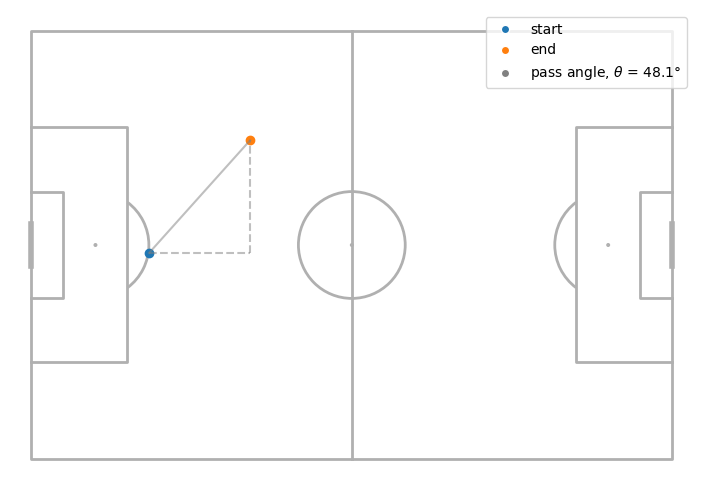

In [460]:
# Calculate angle between two passes
sample_pass = (
    key_actions
    .loc[lambda x: x.eventName == 'Pass']
    .sample(random_state = 350)
    .iloc[:, -4:]
    .values[0]
    .reshape(-2, 2)
)
v1, v2 = sample_pass

# Calculate angle
diff = v2 - v1
directional_angle = np.degrees(np.arctan2(*diff[::-1]))*-1
angle = directional_angle if directional_angle >= 0 else directional_angle + 360

# Initialize pitch
pitch = Pitch()
fig, ax = pitch.draw(nrows = 1, ncols = 1, figsize = (16, 5))

# Plot pass
plt.scatter(*v1, label = 'start')
plt.scatter(*v2, label = 'end')
plt.plot(sample_pass[:, 0], sample_pass[:, 1], color = 'grey', alpha = 0.5)
plt.plot([v1[0], v2[0]], [v1[1]]*2, color = 'grey', ls = '--', alpha = 0.5)
plt.plot([v2[0]]*2, [v1[1], v2[1]], color = 'grey', ls = '--', alpha = 0.5)

# Add legend
marker1 = Line2D([], [], color = 'white', marker = 'o', markerfacecolor = 'tab:blue')
marker2 = Line2D([], [], color = 'white', marker = 'o', markerfacecolor = 'tab:orange')
marker3 = Line2D([], [], color = 'white', marker='o', markerfacecolor = 'grey')
plt.legend([marker1, marker2, marker3], ['start', 'end', r'pass angle, $\theta$ = {:.1f}°'.format(angle)])

plt.show()

### Visualization

In [ ]:
# Radar Chart